In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import site
import numpy as np
import pandas as pd

In [2]:
site.addsitedir('/mnt/home/agabrielpillai/github/') 
import illustris_sam as ilsam

In [3]:
basePath = '/mnt/ceph/users/agabrielpillai/camels_sam/hdf5/CV/CV_0/'

# linkprop and photoprop

We set up everything like the previous examples. In this example we are loading and plotting photometry. To do this, we use `ilsam.photocat`. There are two structures we can load with this module. The first is `linkprop` which contains linking information between `galprop` and `photoprop`.

In [4]:
ilsam.photocat.load_linkprop(basePath, [1, 1, 1], fields=None)

{'LinkpropGalpropIndex': array([    73,     74,     75, ..., 899289, 899290, 899291], dtype=uint32),
 'LinkpropRedshift': array([7.19739  , 6.96749  , 6.49176  , ..., 0.0233739, 0.0113166,
        0.       ], dtype=float32),
 'LinkpropSnapNum': array([10, 11, 12, ..., 97, 98, 99], dtype=uint32)}

The most 'important' one is the field LinkpropGalpropIndex which will allow you to index back into the galprop file for the entire subvolume (note: LinkpropGalpropIndex_Snapshot coming soon). 

Let's look at all the filters available to us right out of the bat. For more about how to create SEDs and photometry, see the example titled `loading_SFHs.ipynb`.  

In [5]:
SAM_photometry = ilsam.photocat.load_photoprop(basePath, [1, 1, 1])
SAM_photometry.keys()

dict_keys(['Photoprop2MASS_H', 'Photoprop2MASS_J', 'Photoprop2MASS_Ks', 'PhotopropGALEX_NUV', 'PhotopropGalex_FUV', 'PhotopropHST_F098M', 'PhotopropHST_F105W', 'PhotopropHST_F110W', 'PhotopropHST_F125W', 'PhotopropHST_F140W', 'PhotopropHST_F160W', 'PhotopropHST_F435W', 'PhotopropHST_F606W', 'PhotopropHST_F775W', 'PhotopropHST_F814W', 'PhotopropHST_F850LP', 'PhotopropJohnson_B', 'PhotopropJohnson_J', 'PhotopropJohnson_U', 'PhotopropJohnson_V', 'PhotopropSDSS_g', 'PhotopropSDSS_i', 'PhotopropSDSS_r', 'PhotopropSDSS_u', 'PhotopropSDSS_z'])

# Verifying snapshot extraction

As an example, let's extract the SDSS photometry at $z \sim 0.25$ (which corresponds to snapshot 80)

In [6]:
def genFullSubvolumes(n):
    subvolume_list = []

    for i in range(n):
        for j in range(n):
            for k in range(n):
                subvolume_list.append([i, j, k])

    return subvolume_list

In [7]:
sdss_fields = ['PhotopropSDSS_u', 'PhotopropSDSS_g', 'PhotopropSDSS_r',  'PhotopropSDSS_i', 'PhotopropSDSS_z']
photo_z_0p25 = ilsam.photocat.load_snapshot_photoprop(basePath, 80, genFullSubvolumes(2), fields = sdss_fields)

Let's now load galprop for the same snapshots ... 

In [8]:
sub_fields = ['GalpropSfr', 'GalpropMstar', 'GalpropSatType',]
sub_z_0p25 = ilsam.groupcat.load_snapshot_subhalos(basePath, 80, genFullSubvolumes(2), fields=sub_fields)

sub_z_0p25

{'GalpropSfr': array([4.37314e-03, 5.63409e-02, 1.35631e-02, ..., 3.01905e-03,
        3.66899e+00, 6.92596e-03], dtype=float32),
 'GalpropMstar': array([1.02265e-01, 1.50785e+00, 1.00168e-01, ..., 3.24438e-02,
        1.56651e+01, 1.19147e-02], dtype=float32),
 'GalpropSatType': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'GalpropSnapNum': array([80., 80., 80., ..., 80., 80., 80.], dtype=float32),
 'n_items': 168101}

We can crudely plot and index as such: 

In [9]:
sub_df_z_0p25 = pd.DataFrame()

for key in sub_z_0p25.keys():
    if key != 'n_items':
        sub_df_z_0p25[key] = sub_z_0p25[key] 
    
photo_df_z_0p25 = pd.DataFrame() 
for key in photo_z_0p25.keys(): 
    photo_df_z_0p25[key] = photo_z_0p25[key] 
    
sub_df_z_0p25 = sub_df_z_0p25[sub_df_z_0p25['GalpropMstar']*1e9 > 1e9].reset_index(drop=True) 

sample_z_0p25 = sub_df_z_0p25.join(photo_df_z_0p25)

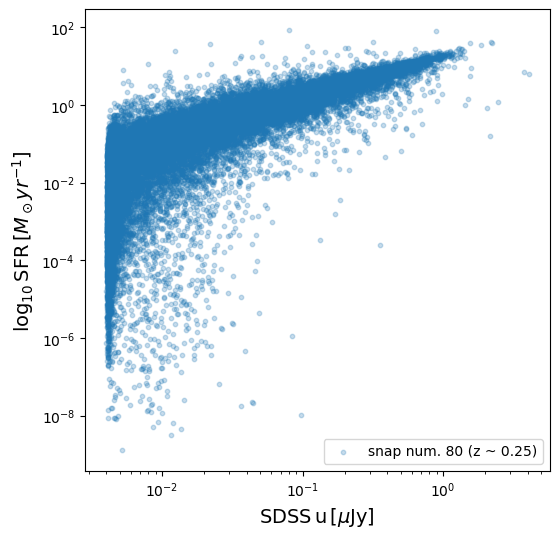

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.scatter(sample_z_0p25['PhotopropSDSS_u'], 
            sample_z_0p25['GalpropSfr'],
            s=10, label='snap num. 80 (z ~ 0.25)', alpha=0.25)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$ {\rm SDSS \, u} \, [\mu {\rm Jy}]$', fontsize=14)
plt.ylabel(r'$\log_{10} {\rm SFR} \, [M_\odot {yr}^{-1}]$', fontsize=14)
plt.legend()

In [16]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)
print(cosmo)

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.05)


In [12]:
def uJy_to_ABmag_SDSS(f_nu):
    '''
    function for calculating AB mag for SDSS filters 
    
    f_nu: flux in band given in micro Janksy [uJy]
    '''
    uJy_to_nMg = 1 / 3.631 # conversion from micro Jansky to nanomaggy for SDSS
    return 22.5 - 2.5*np.log10(f_nu * uJy_to_nMg)

In [14]:
def uJy_to_M(flux, cosmo, z):
    lumDistpc = (cosmo.luminosity_distance(z)*(1e6)).value
    distanceRatio = lumDistpc/10.0
    
    mAB = -2.5*np.log10(flux/(3631e6))
    
    Mest = mAB -5.0*np.log10(lumDistpc/10.0) +  + 2.5*np.log10(1.0+z)
    
    return Mest

/tmp/ipykernel_1838595/1203129798.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


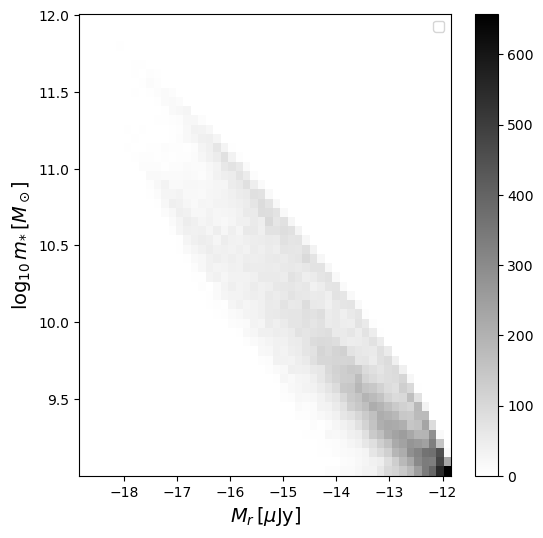

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.hist2d(uJy_to_M(sample_z_0p25['PhotopropSDSS_r'], cosmo, 0.25), 
            np.log10(1e9*sample_z_0p25['GalpropMstar']),
            label='snap num. 80 (z ~ 0.25)', bins=50, cmap='gist_yarg')

# plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'$ M_{r} \, [\mu {\rm Jy}]$', fontsize=14)
plt.ylabel(r'$\log_{10} m_{*} \, [M_\odot]$', fontsize=14)
plt.legend()
plt.colorbar()

# Basic Luminosity "Functions"

In [18]:

# dmag = 0.1
# bins = np.arange(18, 25 + dmag, dmag)


# plt.hist(uJy_to_ABmag_SDSS(sample_z_0p25['PhotopropSDSS_r']), bins=bins, 
#          weights=np.ones(len(sample_z_0p25['PhotopropSDSS_r'])) / dmag / 100**3,
#          label='snap num. 96 (z ~ 0.03)')

# plt.yscale('log')
# plt.xlabel(r'$ {\rm SDSS \, r} \, [{\rm mag}]$', fontsize=14)
# plt.ylabel(r'$N_{\rm bin} [{\rm mag}^{-1} \, {\rm Mpc}^{-3}]$', fontsize=14)
# plt.legend()

# Color-magnitude Diagrams

In [26]:
cond = sample_z_0p25['GalpropMstar'] * 1e9 > 10**9.75

print(sum(cond))

18445


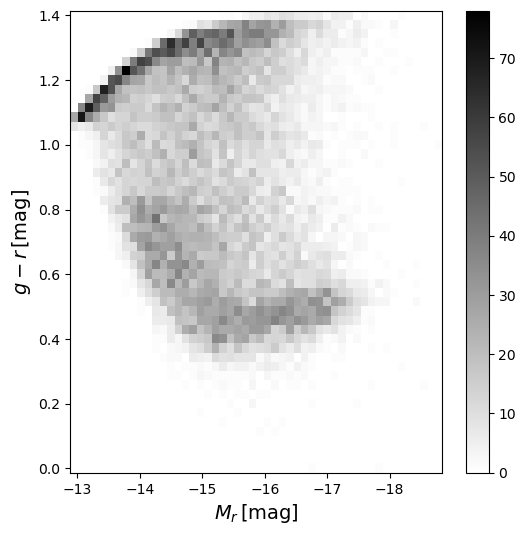

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.hist2d(uJy_to_M((sample_z_0p25['PhotopropSDSS_r'][cond]), cosmo, 0.25), 
           uJy_to_ABmag_SDSS(sample_z_0p25['PhotopropSDSS_g'][cond]) - uJy_to_ABmag_SDSS(sample_z_0p25['PhotopropSDSS_r'][cond]),
          bins=50, cmap='gist_yarg')
           
    
ax.set_xlabel(r'$M_{r} \, [{\rm mag}]$', fontsize=14)
ax.set_ylabel(r'$g - r \, [{\rm mag}]$', fontsize=14)
ax.invert_xaxis()
plt.colorbar()

In [23]:
def MassFunction(ax, mass, volume, th, c='black', l='-', mark='-'):
    # mass = (mass[mass > th])
    
    phi, edg = np.histogram(mass, bins=40, range=(th[0], th[1]))
    phi_i = phi
    dlogM = edg[1] - edg[0] # uniform bin size
    centers = edg[0:-1] + dlogM /  2.0 # x-axis bin centers to plot Phi against; these are log10    
    phi_norm = phi / volume / dlogM 
    ax.plot(centers, np.log10(phi_norm), color = c, label=l, lw = 3, alpha = 1, ls=mark)


/tmp/ipykernel_1838595/160918570.py:9: RuntimeWarning: divide by zero encountered in log10
  ax.plot(centers, np.log10(phi_norm), color = c, label=l, lw = 3, alpha = 1, ls=mark)


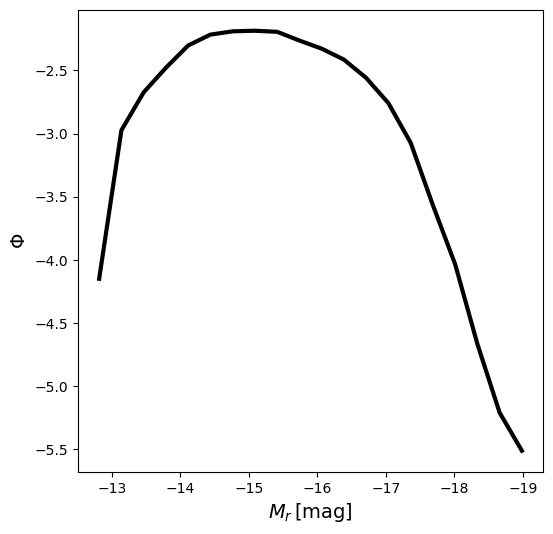

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

MassFunction(ax, uJy_to_M((sample_z_0p25['PhotopropSDSS_r'][cond]), cosmo, 0.25), 100**3, [-25, -12])
ax.set_xlabel(r'$M_{r} \, [{\rm mag}]$', fontsize=14)
ax.set_ylabel(r'$\Phi $', fontsize=14)
ax.invert_xaxis()